In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from skimage.feature import canny
import dlib


In [2]:
# Path dataset lokal
train_folder = 'dataset/final_dataset/train'
test_folder = 'dataset/final_dataset/test'

In [28]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("input_output/shape_predictor_81_face_landmarks.dat")

In [38]:
img_path = "assets/test/1/20.jpg"

img = dlib.load_rgb_image(img_path)


In [39]:
faces= detector(img, 1)

In [40]:
landmark_tuple = []
for k, d in enumerate(faces):
    landmarks = predictor(img, d)
    for n in range (0, 81):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmark_tuple.append((x, y))
        cv2.circle(img, (x, y), 2, (255, 255, 0), -1)

In [41]:
routes = []

# 1. Ambil bagian rahang bawah (landmark 0–16)
for i in range(17):  # Landmark 0 ke 16
    from_coordinate = landmark_tuple[i]
    routes.append(from_coordinate)

# 2. Sambungkan ke sisi kanan dahi (landmark 78–79)
for i in range(78, 80):  # Landmark 78 ke 79
    from_coordinate = landmark_tuple[i]
    routes.append(from_coordinate)

# 3. Ambil hanya satu titik dari sisi atas dahi (landmark 71)
routes.append(landmark_tuple[71])  # Hanya titik 71

# 4. Ambil hanya satu titik dari sisi kiri dahi (landmark 76)
routes.append(landmark_tuple[76])  # Hanya titik 76

# 5. Tutup poligon dengan kembali ke titik awal (landmark 0)
routes.append(landmark_tuple[0])  # Kembali ke titik 0


In [31]:
routes = []

for i in range(15, -1, -1):
    from_coordinate = landmark_tuple[i+1]
    to_coordinate = landmark_tuple[i]
    routes.append(from_coordinate)

from_coordinate = landmark_tuple[0]
to_coordinate =landmark_tuple[17]
routes.append(from_coordinate)

for i in range(17, 20):
    from_coordinate = landmark_tuple[i+1]
    to_coordinate = landmark_tuple[i+1]
    routes.append(from_coordinate)

from_coordinate = landmark_tuple[19]
to_coordinate =landmark_tuple[24]
routes.append(from_coordinate)

for i in range(24, 26):
    from_coordinate = landmark_tuple[i+1]
    to_coordinate = landmark_tuple[i+1]
    routes.append(from_coordinate)

from_coordinate = landmark_tuple[26]
to_coordinate =landmark_tuple[16]
routes.append(from_coordinate)

In [42]:
for i in range(len(routes) - 1):
    from_coordinate = tuple(routes[i])       # Pastikan koordinat berupa tuple (x, y)
    to_coordinate = tuple(routes[i + 1])    # Ambil koordinat berikutnya
    img = cv2.line(img, from_coordinate, to_coordinate, (255, 255, 255), thickness=2)


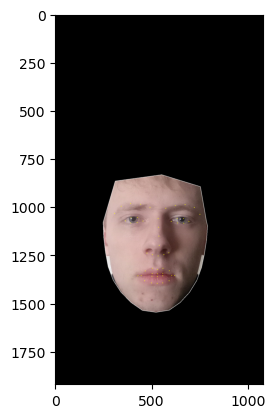

In [44]:
import matplotlib.pyplot as plt

mask = np.zeros((img.shape[0], img.shape[1]))
mask = cv2.fillConvexPoly(mask, np.array(routes), 1)
mask = mask.astype(bool)

out = np.zeros_like(img)
out[mask] = img[mask]

plt.imshow(out)

In [52]:
def detect_landmarks(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = detector(img_gray)
    if len(faces) == 0:
        return None  # Tidak ada wajah yang terdeteksi
    
    # Ambil landmark dari wajah pertama yang terdeteksi
    face = faces[0]
    landmarks = predictor(img_gray, face)
    landmark_points = [(p.x, p.y) for p in landmarks.parts()]
    
    return landmark_points

In [50]:
def face_segmentation(img, landmarks):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    
    # Landmark untuk bagian wajah (sesuai dengan pola 0-16, 78-79, 71, 76, 0)
    routes = []
    for i in range(17):  # Rahang bawah (0–16)
        routes.append(landmarks[i])
    for i in range(78, 80):  # Sisi kanan dahi (78–79)
        routes.append(landmarks[i])
    routes.append(landmarks[71])  # Satu titik sisi atas dahi
    routes.append(landmarks[76])  # Satu titik sisi kiri dahi
    routes.append(landmarks[0])  # Kembali ke awal (0)

    # Bentuk polygon pada mask
    routes = np.array(routes, dtype=np.int32)
    cv2.fillConvexPoly(mask, routes, 255)
    
    # Terapkan mask pada gambar
    segmented_img = cv2.bitwise_and(img, img, mask=mask)
    return segmented_img

In [58]:
def preprocess_image(img_path, size=(200, 200)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Ubah ke grayscale
    img = cv2.resize(img, size)  # Resize gambar

    # Deteksi landmark
    landmarks = detect_landmarks(img_path)
    if landmarks is not None:
        img = face_segmentation(img, landmarks)  # Segmentasi wajah
    
    return img

In [59]:
# Defining a function to return the class labels corresponding to the age-ranges shown above.
def class_labels(age):
    if 0 <= age <= 12:
        return 0
    elif 13 <= age <= 20:
        return 1
    elif 21 <= age <= 30:
        return 2
    elif 31 <= age <= 40:
        return 3
    elif 41 <= age <= 50:
        return 4
    else:
        return 5

In [60]:
def load_images_and_labels(folder_path):
    data = []
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file_name)
                
                # Ambil angka pertama sebelum '_', yang diasumsikan sebagai usia
                try:
                    age = int(file_name.split('_')[0])  # Angka pertama sebelum '_'
                    label = class_labels(age)  # Menggunakan fungsi class_labels untuk menentukan label
                    data.append((file_path, label))  # Path dan label
                except ValueError:
                    continue  # Lewati file yang tidak dapat diambil angkanya
                
    return pd.DataFrame(data, columns=['filepath', 'label'])

In [61]:
# Load data train dan test
train_df = load_images_and_labels(train_folder)
test_df = load_images_and_labels(test_folder)

In [ ]:
def extract_features_from_image(img_path, size=(200, 200)):
    img = preprocess_image(img_path, size) 
    img = canny(img, sigma=0.9)  
    
    features = []
    for y in range(0, size[0], 10):
        for x in range(0, size[1], 10):
            section = img[y:y+10, x:x+10]
            features.append(np.mean(section))
            features.append(np.std(section))
    return np.array(features)

In [63]:
def extract_features(data_df):
    features = []
    labels = []
    for _, row in data_df.iterrows():
        img_features = extract_features_from_image(row['filepath'])
        features.append(img_features)
        labels.append(row['label'])
    return np.array(features), np.array(labels)

In [64]:
X_train, y_train = extract_features(train_df)

In [65]:
X_test, y_test = extract_features(test_df)

In [66]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [73]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Membuat model XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)

# Melatih model
xgb_model.fit(X_train_sc, y_train)

# Evaluasi model
y_pred_xgb = xgb_model.predict(X_test_sc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(cm)

# Akurasi Model
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: {accuracy * 100:.2f}%")

Confusion Matrix:
[[434  29  25  12   3   7]
 [ 31 375  49  33  16   6]
 [ 23  61 260  95  48  23]
 [  9  44 127 209  94  27]
 [  7  14  48  76 307  58]
 [ 13   9  19  46  84 339]]
Accuracy: 62.88%


In [74]:
import pickle

# Saving the SVM model in a pickle file for possible use later.
accuracy = accuracy_score(y_test, y_pred_xgb)  # Get accuracy
svm_pickle = f"model/xgb_model_acc_{round(accuracy, 2)}.pkl"
with open(svm_pickle, 'wb') as file:
    pickle.dump(xgb_model, file)

In [72]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Model SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_sc, y_train)

# Evaluasi
y_pred = svm_model.predict(X_test_sc)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Akurasi Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Confusion Matrix:
[[415  45  25  14   5   6]
 [ 61 328  72  39   7   3]
 [ 54  90 191 116  45  14]
 [ 38  59 123 181  73  36]
 [ 23  52  56  92 223  64]
 [ 23  23  34  70 111 249]]
Accuracy: 51.86%
